In [44]:
#CS260 - Mohit Khatri
#Student ID: 862547409
!pip -q install numba

In [45]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.linalg import norm
from numba import njit, prange
import math

from sklearn.datasets import load_diabetes, load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [46]:
# ---------- small plotting helper ----------
def set_figsize(w=8, h=5):
    plt.rcParams["figure.figsize"] = (w, h)
    plt.rcParams["font.family"] = "serif"

np.random.seed(10)

# ---------- precision emulation ----------
_MODE_ID = {"fp32": 0, "bf16": 1, "tf32": 2}

@njit
def round_to_pbits(x, p):
    # Round to p explicit mantissa bits (hidden bit handled via frexp/ldexp)
    if np.isnan(x) or np.isinf(x) or x == 0.0:
        return x
    m, e = math.frexp(x)
    sgn = 1.0 if m >= 0 else -1.0
    m = abs(m)
    scale = 1 << (p + 1)          # include hidden bit
    m_q = np.round(m * scale) / scale
    if m_q >= 1.0:
        m_q = 0.5
        e += 1
    return math.ldexp(sgn * m_q, e)

@njit
def round_scalar_by_mode(x, mode_id):
    x32 = np.float32(x)
    if mode_id == 0:               # FP32  (23 mantissa bits)
        return x32
    elif mode_id == 1:             # BF16  (7 mantissa bits)
        return np.float32(round_to_pbits(x32, 7))
    else:                           # TF32  (10 mantissa bits)
        return np.float32(round_to_pbits(x32, 10))

@njit(parallel=True)
def _round_array_1d(a, mode_id):
    n = a.shape[0]
    for i in prange(n):
        a[i] = round_scalar_by_mode(a[i], mode_id)

@njit(parallel=True)
def _round_array_2d(a, mode_id):
    m, n = a.shape
    for i in prange(m):
        for j in range(n):
            a[i, j] = round_scalar_by_mode(a[i, j], mode_id)

def convert_precision(x, mode="fp32"):
    # Round numpy array/scalar to chosen working precision
    mode_id = _MODE_ID.get(mode, 0)
    a = np.asarray(x, dtype=np.float32).copy()
    if a.size == 0:
        return a
    if a.ndim == 1:
        _round_array_1d(a, mode_id)
    elif a.ndim == 2:
        _round_array_2d(a, mode_id)
    else:
        a2 = a.reshape(-1, 1)
        _round_array_2d(a2, mode_id)
        a = a2.reshape(a.shape)
    if np.isscalar(x) and a.size == 1:
        return a.item()
    return a

In [47]:
print("--- quick conversion sanity ---")
x = np.array([1.23, -4.56, 100.0, 0.001, np.pi, 1e-6], dtype=np.float32)
for m in ["fp32", "bf16", "tf32"]:
    print(f"{m:5s}", convert_precision(x, m))

--- quick conversion sanity ---
fp32  [ 1.2300000e+00 -4.5599999e+00  1.0000000e+02  1.0000000e-03
  3.1415927e+00  1.0000000e-06]
bf16  [ 1.2265625e+00 -4.5625000e+00  1.0000000e+02  9.9945068e-04
  3.1406250e+00  9.9837780e-07]
tf32  [ 1.2304688e+00 -4.5585938e+00  1.0000000e+02  1.0004044e-03
  3.1406250e+00  1.0002404e-06]


In [48]:
# ---------- GEMM (faithful per-op rounding) ----------
@njit(parallel=True)
def _gemm_numba_faithful(A, B, mode_id):
    M, K = A.shape
    N = B.shape[1]
    C = np.zeros((M, N), dtype=np.float32)
    for i in prange(M):
        for j in range(N):
            s = round_scalar_by_mode(0.0, mode_id)
            for k in range(K):
                prod = round_scalar_by_mode(A[i, k] * B[k, j], mode_id)
                s = round_scalar_by_mode(s + prod, mode_id)
            C[i, j] = round_scalar_by_mode(s, mode_id)
    return C

def simulated_gemm(A, B, mode="fp32"):
    mode_id = _MODE_ID.get(mode, 0)
    Ap = convert_precision(A, mode)
    Bp = convert_precision(B, mode)
    return _gemm_numba_faithful(Ap, Bp, mode_id)

def rel_fro_error(C, Cref):
    return float(norm(C.astype(np.float64) - Cref, "fro") / (norm(Cref, "fro") + 1e-30))

def run_gemm_benchmark(matrix_sizes, num_runs=1):
    print("\n--- GEMM Accuracy Benchmark (Faithful N^3) ---")
    modes = ["fp32", "tf32", "bf16"]
    all_errors = {m: [] for m in modes}
    rng = np.random.default_rng(10)
    for n in matrix_sizes:
        print(f"n={n} ...")
        A = (rng.standard_normal((n, n)) * 10.0).astype(np.float64)
        B = (rng.standard_normal((n, n)) * 10.0).astype(np.float64)
        Cref = A @ B
        for m in modes:
            errs = []
            for _ in range(num_runs):
                Cq = simulated_gemm(A, B, mode=m)
                errs.append(rel_fro_error(Cq, Cref))
            all_errors[m].append(float(np.mean(errs)))
    return all_errors

def plot_gemm_results(matrix_sizes, all_errors):
    set_figsize(8, 6)
    plt.figure()
    for m in ["fp32", "tf32", "bf16"]:
        plt.loglog(matrix_sizes, all_errors[m], marker="o", label=m.upper())
    plt.title("Accuracy of GEMM vs Size (faithful per-op rounding)")
    plt.xlabel("matrix size n (log)")
    plt.ylabel(r"relative error $\|C_q - C_{ref}\|_F / \|C_{ref}\|_F$ (log)")
    plt.grid(True, which="both", ls="--", alpha=0.6)
    plt.legend(loc="upper left")
    plt.show()


--- GEMM Accuracy Benchmark (Faithful N^3) ---
n=64 ...
n=128 ...
n=256 ...
n=512 ...


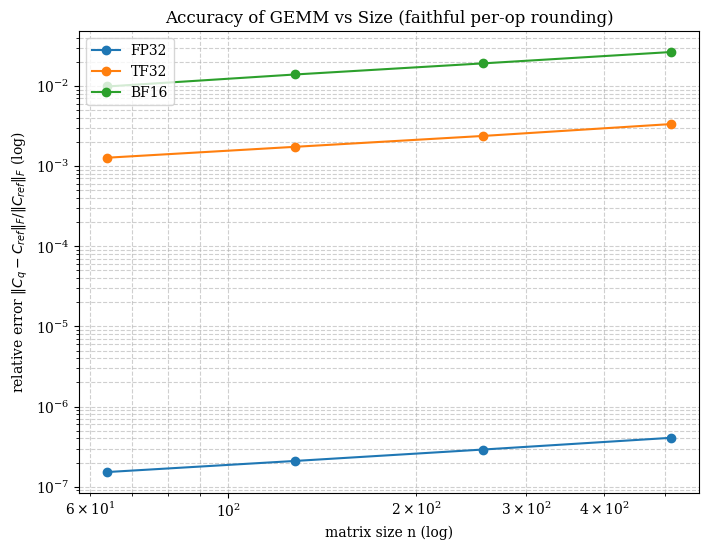


GEMM done.



In [49]:
SIZES = [64, 128, 256, 512]
errors = run_gemm_benchmark(SIZES, num_runs=1)
plot_gemm_results(SIZES, errors)
print("\nGEMM done.\n")

In [50]:
# Linear Regression
@njit(parallel=True)
def _matvec_round(X, w, b, mode_id):
    n, d = X.shape
    yhat = np.empty((n, 1), dtype=np.float32)
    for i in prange(n):
        s = round_scalar_by_mode(0.0, mode_id)
        for j in range(d):
            prod = round_scalar_by_mode(X[i, j] * w[j, 0], mode_id)
            s = round_scalar_by_mode(s + prod, mode_id)
        s = round_scalar_by_mode(s + b, mode_id)
        yhat[i, 0] = s
    return yhat

@njit
def _mse_loss_round(e, mode_id):
    n = e.shape[0]
    s = round_scalar_by_mode(0.0, mode_id)
    for i in range(n):
        sq = round_scalar_by_mode(e[i, 0] * e[i, 0], mode_id)
        s = round_scalar_by_mode(s + sq, mode_id)
    invn = round_scalar_by_mode(1.0 / n, mode_id)
    return round_scalar_by_mode(s * invn, mode_id)

@njit
def _grads_round(X, e, mode_id):
    n, d = X.shape
    gw = np.zeros((d, 1), dtype=np.float32)
    gb = round_scalar_by_mode(0.0, mode_id)
    for i in range(n):
        gb = round_scalar_by_mode(gb + e[i, 0], mode_id)
    for j in range(d):
        s = round_scalar_by_mode(0.0, mode_id)
        for i in range(n):
            prod = round_scalar_by_mode(X[i, j] * e[i, 0], mode_id)
            s = round_scalar_by_mode(s + prod, mode_id)
        gw[j, 0] = s
    two_over_n = round_scalar_by_mode(2.0 / n, mode_id)
    for j in range(d):
        gw[j, 0] = round_scalar_by_mode(gw[j, 0] * two_over_n, mode_id)
    gb = round_scalar_by_mode(gb * two_over_n, mode_id)
    return gw, gb

@njit
def _step_round(w, b, gw, gb, alpha, mode_id):
    d = w.shape[0]
    for j in range(d):
        upd = round_scalar_by_mode(alpha * gw[j, 0], mode_id)
        w[j, 0] = round_scalar_by_mode(w[j, 0] - upd, mode_id)
    ub = round_scalar_by_mode(alpha * gb, mode_id)
    b = round_scalar_by_mode(b - ub, mode_id)
    return w, b

@njit
def _lr_epoch_round(X, y, w, b, alpha, mode_id):
    yhat = _matvec_round(X, w, b, mode_id)
    n = y.shape[0]
    e = np.empty_like(yhat)
    for i in range(n):
        e[i, 0] = round_scalar_by_mode(yhat[i, 0] - y[i, 0], mode_id)
    loss = _mse_loss_round(e, mode_id)
    gw, gb = _grads_round(X, e, mode_id)
    w, b = _step_round(w, b, gw, gb, alpha, mode_id)
    return w, b, loss

def linear_regression_gd_faithful(X, y, mode="fp32", learning_rate=1e-2, epochs=300):
    mode_id = _MODE_ID.get(mode, 0)
    Xp = convert_precision(np.asarray(X, np.float32), mode)
    yp = convert_precision(np.asarray(y, np.float32).reshape(-1, 1), mode)
    w  = convert_precision(np.zeros((Xp.shape[1], 1), np.float32), mode)
    b  = convert_precision(0.0, mode)
    alpha = convert_precision(learning_rate, mode)
    losses = []
    _ = _lr_epoch_round(Xp[:1], yp[:1], w[:1], b, alpha, mode_id)  # JIT warmup
    for _ in range(epochs):
        w, b, loss = _lr_epoch_round(Xp, yp, w, b, alpha, mode_id)
        losses.append(float(loss))
    return w, b, np.array(losses, dtype=np.float64)

def predict_lr_faithful(X, w, b, mode="fp32"):
    mode_id = _MODE_ID.get(mode, 0)
    Xp = convert_precision(np.asarray(X, np.float32), mode)
    yhat = _matvec_round(Xp, w, b, mode_id)
    return yhat.ravel().astype(np.float32)

def get_diabetes_split(test_size=0.25, seed=0):
    data = load_diabetes()
    X = data.data.astype(np.float32)
    y = data.target.astype(np.float32)
    Xtr, Xte, ytr, yte = train_test_split(X, y, test_size=test_size, random_state=seed)
    scaler = StandardScaler()
    Xtr = scaler.fit_transform(Xtr).astype(np.float32)
    Xte = scaler.transform(Xte).astype(np.float32)
    return Xtr, Xte, ytr, yte

def run_lr_diabetes_benchmark(epochs=200, lr=1e-2):
    Xtr, Xte, ytr, yte = get_diabetes_split(test_size=0.25, seed=42)
    modes = ["fp32", "tf32", "bf16"]
    losses, final_scores = {}, {}
    for m in modes:
        print(f"Train LR (faithful) on Diabetes under {m} ...")
        w, b, L = linear_regression_gd_faithful(Xtr, ytr, mode=m, learning_rate=lr, epochs=epochs)
        losses[m] = L
        yhat_tr = predict_lr_faithful(Xtr, w, b, mode=m)
        yhat_te = predict_lr_faithful(Xte, w, b, mode=m)
        mse_tr = float(np.mean((yhat_tr - ytr) ** 2))
        mse_te = float(np.mean((yhat_te - yte) ** 2))
        final_scores[m] = {"train_mse": mse_tr, "test_mse": mse_te}
    return losses, final_scores

def plot_lr_losses(losses_by_mode, title="Linear Regression (Diabetes, faithful) – Loss vs Epoch"):
    set_figsize(8, 5)
    plt.figure()
    for m in ["fp32", "tf32", "bf16"]:
        plt.plot(losses_by_mode[m], label=m.upper())
    plt.yscale("log")
    plt.title(title)
    plt.xlabel("epoch"); plt.ylabel("MSE (log)")
    plt.grid(True, alpha=0.4); plt.legend(); plt.show()

Running LR (faithful) on Diabetes ...
Train LR (faithful) on Diabetes under fp32 ...
Train LR (faithful) on Diabetes under tf32 ...
Train LR (faithful) on Diabetes under bf16 ...


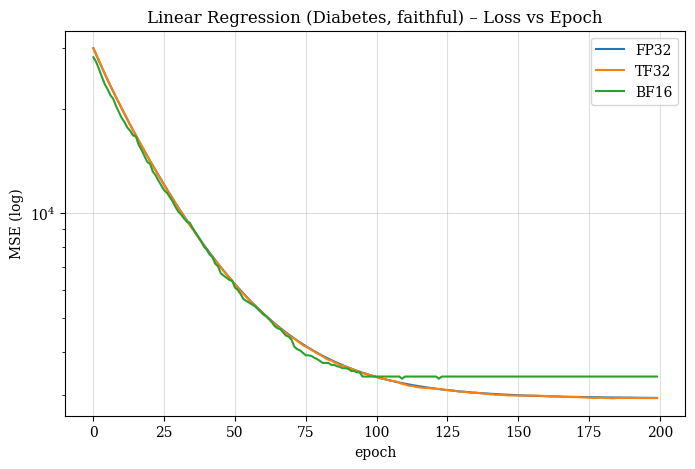

Final MSE (train / test):
  FP32  -> train: 2944.2095 | test: 2849.0667
  TF32  -> train: 2946.4868 | test: 2850.8481
  BF16  -> train: 3554.2280 | test: 3504.9031

LR (faithful) done.



In [51]:
print("Running LR (faithful) on Diabetes ...")
lr_losses, lr_scores = run_lr_diabetes_benchmark(epochs=200, lr=1e-2)
plot_lr_losses(lr_losses)
print("Final MSE (train / test):")
for k, v in lr_scores.items():
    print(f"  {k.upper():5s} -> train: {v['train_mse']:.4f} | test: {v['test_mse']:.4f}")
print("\nLR (faithful) done.\n")

In [52]:
# Logistic Regression
@njit
def _sigmoid_round(x, mode_id):
    neg = round_scalar_by_mode(-x, mode_id)
    e   = round_scalar_by_mode(math.exp(neg), mode_id)
    den = round_scalar_by_mode(1.0 + e, mode_id)
    return round_scalar_by_mode(1.0 / den, mode_id)

@njit(parallel=True)
def _logreg_forward_round(X, w, b, mode_id):
    n, d = X.shape
    yhat = np.empty((n, 1), dtype=np.float32)
    for i in prange(n):
        s = round_scalar_by_mode(0.0, mode_id)
        for j in range(d):
            prod = round_scalar_by_mode(X[i, j] * w[j, 0], mode_id)
            s = round_scalar_by_mode(s + prod, mode_id)
        s = round_scalar_by_mode(s + b, mode_id)
        yhat[i, 0] = _sigmoid_round(s, mode_id)
    return yhat

@njit
def _bce_loss_round(y, yhat, mode_id):
    n = y.shape[0]
    s = round_scalar_by_mode(0.0, mode_id)
    eps = 1e-6
    for i in range(n):
        yi = y[i, 0]
        pi = yhat[i, 0]
        if pi < eps:
            pi = eps
        elif pi > 1 - eps:
            pi = 1 - eps
        t1 = round_scalar_by_mode(yi * math.log(pi), mode_id)
        t2 = round_scalar_by_mode((1 - yi) * math.log(1 - pi), mode_id)
        s = round_scalar_by_mode(s + t1 + t2, mode_id)
    invn = round_scalar_by_mode(-1.0 / n, mode_id)
    return round_scalar_by_mode(s * invn, mode_id)

@njit
def _logreg_grads_round(X, y, yhat, mode_id):
    n, d = X.shape
    gw = np.zeros((d, 1), dtype=np.float32)
    gb = round_scalar_by_mode(0.0, mode_id)
    for j in range(d):
        s = round_scalar_by_mode(0.0, mode_id)
        for i in range(n):
            diff = round_scalar_by_mode(yhat[i, 0] - y[i, 0], mode_id)
            prod = round_scalar_by_mode(X[i, j] * diff, mode_id)
            s = round_scalar_by_mode(s + prod, mode_id)
        gw[j, 0] = s
    for i in range(n):
        gb = round_scalar_by_mode(gb + (yhat[i, 0] - y[i, 0]), mode_id)
    scale = round_scalar_by_mode(1.0 / n, mode_id)
    for j in range(d):
        gw[j, 0] = round_scalar_by_mode(gw[j, 0] * scale, mode_id)
    gb = round_scalar_by_mode(gb * scale, mode_id)
    return gw, gb

@njit
def _logreg_step_round(w, b, gw, gb, alpha, mode_id):
    d = w.shape[0]
    for j in range(d):
        upd = round_scalar_by_mode(alpha * gw[j, 0], mode_id)
        w[j, 0] = round_scalar_by_mode(w[j, 0] - upd, mode_id)
    ub = round_scalar_by_mode(alpha * gb, mode_id)
    b = round_scalar_by_mode(b - ub, mode_id)
    return w, b

def logistic_regression_faithful(X, y, mode="fp32", learning_rate=0.05, epochs=200):
    mode_id = _MODE_ID.get(mode, 0)
    Xp = convert_precision(X.astype(np.float32), mode)
    yp = convert_precision(y.astype(np.float32).reshape(-1, 1), mode)
    w  = convert_precision(np.zeros((Xp.shape[1], 1)), mode)
    b  = convert_precision(0.0, mode)
    alpha = convert_precision(learning_rate, mode)
    losses = []
    _ = _logreg_forward_round(Xp[:1], w[:1], b, mode_id)  # warmup
    for _ in range(epochs):
        yhat = _logreg_forward_round(Xp, w, b, mode_id)
        loss = _bce_loss_round(yp, yhat, mode_id)
        gw, gb = _logreg_grads_round(Xp, yp, yhat, mode_id)
        w, b = _logreg_step_round(w, b, gw, gb, alpha, mode_id)
        losses.append(float(loss))
    return w, b, np.array(losses, dtype=np.float64)

# ----- Breast Cancer dataset for logistic regression -----
def get_breast_cancer_split(test_size=0.25, seed=0):
    data = load_breast_cancer()
    X = data.data.astype(np.float32)
    y = data.target.astype(np.float32)
    Xtr, Xte, ytr, yte = train_test_split(X, y, test_size=test_size, random_state=seed)
    scaler = StandardScaler()
    Xtr = scaler.fit_transform(Xtr).astype(np.float32)
    Xte = scaler.transform(Xte).astype(np.float32)
    return Xtr, Xte, ytr, yte

def run_logreg_breast_cancer(epochs=200, lr=0.05):
    Xtr, Xte, ytr, yte = get_breast_cancer_split(test_size=0.25, seed=42)
    modes = ["fp32", "tf32", "bf16"]
    losses, final_scores = {}, {}
    for m in modes:
        print(f"Train LogReg (faithful) on Breast Cancer under {m} ...")
        w, b, L = logistic_regression_faithful(Xtr, ytr, mode=m, learning_rate=lr, epochs=epochs)
        losses[m] = L
        # evaluate with faithful forward pass
        yhat_tr = _logreg_forward_round(convert_precision(Xtr, m), w, b, _MODE_ID[m]).ravel()
        yhat_te = _logreg_forward_round(convert_precision(Xte, m), w, b, _MODE_ID[m]).ravel()
        preds_tr = (yhat_tr >= 0.5).astype(np.float32)
        preds_te = (yhat_te >= 0.5).astype(np.float32)
        acc_tr = float(np.mean(preds_tr == ytr))
        acc_te = float(np.mean(preds_te == yte))
        # BCE eval (FP32 compute on probabilities)
        eps = 1e-10
        bce_te = float(-np.mean(yte * np.log(np.clip(yhat_te, eps, 1 - eps)) +
                                (1 - yte) * np.log(np.clip(1 - yhat_te, eps, 1 - eps))))
        final_scores[m] = {"train_acc": acc_tr, "test_acc": acc_te, "test_bce": bce_te}
    return losses, final_scores

def plot_logreg_losses(losses_by_mode, title="Logistic Regression (Breast Cancer, faithful) – Loss vs Epoch"):
    set_figsize(8, 5)
    plt.figure()
    for m in ["fp32", "tf32", "bf16"]:
        plt.plot(losses_by_mode[m], label=m.upper())
    plt.yscale("log")
    plt.title(title)
    plt.xlabel("epoch"); plt.ylabel("BCE loss (log)")
    plt.grid(True, alpha=0.4); plt.legend(); plt.show()

Running Logistic Regression (faithful) on Breast Cancer ...
Train LogReg (faithful) on Breast Cancer under fp32 ...
Train LogReg (faithful) on Breast Cancer under tf32 ...
Train LogReg (faithful) on Breast Cancer under bf16 ...


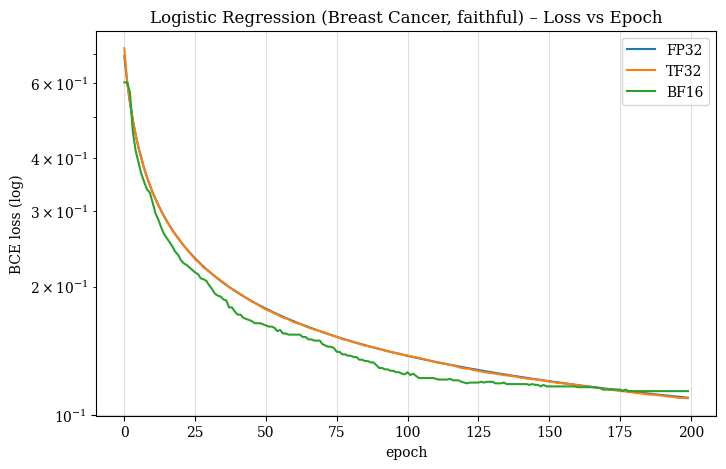

Final Accuracy / Test-BCE:
  FP32  -> acc_train: 0.9812 | acc_test: 0.9860 | bce_test: 0.0870
  TF32  -> acc_train: 0.9812 | acc_test: 0.9860 | bce_test: 0.0871
  BF16  -> acc_train: 0.9789 | acc_test: 0.9790 | bce_test: 0.1018

LogReg (faithful) done.


In [53]:
print("Running Logistic Regression (faithful) on Breast Cancer ...")
log_losses, log_scores = run_logreg_breast_cancer(epochs=200, lr=0.05)
plot_logreg_losses(log_losses)
print("Final Accuracy / Test-BCE:")
for k, v in log_scores.items():
    print(f"  {k.upper():5s} -> acc_train: {v['train_acc']:.4f} | acc_test: {v['test_acc']:.4f} | bce_test: {v['test_bce']:.4f}")
print("\nLogReg (faithful) done.")

In [54]:
import torch
import numpy as np

# Manual BF16 rounding (faithful)
def to_bf16(x):
    x32 = np.float32(x)
    bf16 = np.frombuffer(x32.tobytes(), dtype=np.uint16)
    # keep sign+exponent+7 mantissa bits: mask = 0xFF80
    bf16 = bf16 & 0xFF80
    return np.frombuffer(bf16.tobytes(), dtype=np.float32)[0]

def bf16_mul_faithful(a, b):
    a_bf = to_bf16(a)
    b_bf = to_bf16(b)
    prod = a_bf * b_bf
    return to_bf16(prod)

a = 1.0009766   # smallest change representable in BF16
b = 1.0009766

print("faithful bf16 product:", bf16_mul_faithful(a, b))

faithful bf16 product: 1.0019531


In [55]:
import torch

a_t = torch.tensor(a, dtype=torch.bfloat16)
b_t = torch.tensor(b, dtype=torch.bfloat16)
print("pytorch bf16 product:", (a_t * b_t))

pytorch bf16 product: tensor(1., dtype=torch.bfloat16)


In [58]:
# K-means

@njit
def _sqdist_point_centroid(xi, mu_k, mode_id, mixed_accum):
    d = xi.shape[0]
    if mixed_accum:
        s = 0.0
        for j in range(d):
            diff = xi[j] - mu_k[j]
            s += diff * diff
        return round_scalar_by_mode(s, mode_id)
    else:
        s = round_scalar_by_mode(0.0, mode_id)
        for j in range(d):
            diff = round_scalar_by_mode(xi[j] - mu_k[j], mode_id)
            s = round_scalar_by_mode(s + round_scalar_by_mode(diff * diff, mode_id), mode_id)
        return s

@njit(parallel=True)
def _assign_step_faithful(X, mu, mode_id, mixed_accum):
    n, _ = X.shape
    k = mu.shape[0]
    labels = np.empty(n, dtype=np.int32)
    for i in prange(n):
        best_k = 0
        best_d = _sqdist_point_centroid(X[i], mu[0], mode_id, mixed_accum)
        for c in range(1, k):
            di = _sqdist_point_centroid(X[i], mu[c], mode_id, mixed_accum)
            if di < best_d:
                best_d = di
                best_k = c
        labels[i] = best_k
    return labels

@njit(parallel=True)
def _update_step_faithful(X, labels, k, mode_id, mixed_accum):
    n, d = X.shape
    mu_new = np.zeros((k, d), dtype=np.float32)
    counts = np.zeros(k, dtype=np.int32)

    # accumulate sums (parallel)
    for i in prange(n):
        c = labels[i]
        counts[c] += 1
        if mixed_accum:
            for j in range(d):
                mu_new[c, j] += X[i, j]
        else:
            for j in range(d):
                mu_new[c, j] = round_scalar_by_mode(mu_new[c, j] + X[i, j], mode_id)

    # divide by counts (sequential; rounding)
    for c in range(k):
        if counts[c] > 0:
            inv = round_scalar_by_mode(1.0 / counts[c], mode_id)
            for j in range(d):
                mu_new[c, j] = round_scalar_by_mode(mu_new[c, j] * inv, mode_id)
    return mu_new

@njit(parallel=True)
def _point_inertia_array(X, mu, labels, mode_id, mixed_accum):
    # per-point squared distance to its centroid (parallel-friendly)
    n, _ = X.shape
    arr = np.empty(n, dtype=np.float32)
    for i in prange(n):
        c = labels[i]
        arr[i] = _sqdist_point_centroid(X[i], mu[c], mode_id, mixed_accum)
    return arr

@njit
def _sum_with_rounding(arr, mode_id):
    s = round_scalar_by_mode(0.0, mode_id)
    for i in range(arr.shape[0]):
        s = round_scalar_by_mode(s + arr[i], mode_id)
    return float(s)

@njit
def _centroid_max_drift(mu_old, mu_new, mode_id, mixed_accum):
    k, d = mu_new.shape
    max_drift = 0.0
    for c in range(k):
        if mixed_accum:
            s = 0.0
            for j in range(d):
                diff = mu_new[c, j] - mu_old[c, j]
                s += diff * diff
            dist = float(s) ** 0.5
        else:
            s = round_scalar_by_mode(0.0, mode_id)
            for j in range(d):
                diff = round_scalar_by_mode(mu_new[c, j] - mu_old[c, j], mode_id)
                s = round_scalar_by_mode(s + round_scalar_by_mode(diff * diff, mode_id), mode_id)
            dist = float(s) ** 0.5
        if dist > max_drift:
            max_drift = dist
    return max_drift

def kmeans_faithful(X, k=8, mode="fp32", max_iters=50, tol=1e-4, seed=0, mixed_accum=False, init_mu=None):
    mode_id = _MODE_ID.get(mode, 0)
    rng = np.random.default_rng(seed)
    Xp = convert_precision(np.asarray(X, np.float32), mode)

    if init_mu is None:
        idx = rng.choice(Xp.shape[0], size=k, replace=False)
        mu = convert_precision(Xp[idx].copy(), mode)
    else:
        mu = convert_precision(np.asarray(init_mu, np.float32).copy(), mode)

    inertia_hist, drift_hist = [], []
    for _ in range(max_iters):
        labels = _assign_step_faithful(Xp, mu, mode_id, mixed_accum)
        mu_new = _update_step_faithful(Xp, labels, k, mode_id, mixed_accum)

        # per-point inertia in parallel, then sum with rounding sequentially
        arr = _point_inertia_array(Xp, mu_new, labels, mode_id, mixed_accum)
        inertia = _sum_with_rounding(arr, mode_id)

        drift = _centroid_max_drift(mu, mu_new, mode_id, mixed_accum)

        inertia_hist.append(inertia)
        drift_hist.append(drift)
        mu = mu_new
        if drift < tol:
            break

    return {
        "centroids": mu,                                # final (k,d)
        "labels": labels,                               # final (n,)
        "inertia": np.array(inertia_hist, dtype=np.float64),
        "drift":   np.array(drift_hist,   dtype=np.float64),
    }

def kmeans_multi_run(X, k=8, modes=("fp32","tf32","bf16"), iters=40, tol=1e-4, runs=10, mixed_accum=False, seed_base=1234):
      stats = {m: {"inertia": [], "drift": [], "assignments": []} for m in modes}

      for r in range(runs):
          print(f"\n--- Run {r+1}/{runs} ---")

          # Build one shared init on FP32 for fairness
          rng = np.random.default_rng(seed_base + r)
          Xf = np.asarray(X, np.float32)
          init_idx = rng.choice(Xf.shape[0], size=k, replace=False)
          init_mu  = Xf[init_idx].copy()

          # FP32 reference
          res_fp32 = kmeans_faithful(X, k=k, mode="fp32", max_iters=iters, tol=tol,
                                    mixed_accum=mixed_accum, init_mu=init_mu)
          ref_assign = res_fp32["labels"]

          stats["fp32"]["inertia"].append(res_fp32["inertia"][-1])
          stats["fp32"]["drift"].append(res_fp32["drift"][-1])
          stats["fp32"]["assignments"].append(0)  # 0 diff by definition

          # Other modes with same init
          for m in modes:
              if m == "fp32":
                  continue
              res = kmeans_faithful(X, k=k, mode=m, max_iters=iters, tol=tol,
                                    mixed_accum=mixed_accum, init_mu=init_mu)
              final_assign = res["labels"]
              diff = int(np.sum(final_assign != ref_assign))

              stats[m]["inertia"].append(res["inertia"][-1])
              stats[m]["drift"].append(res["drift"][-1])
              stats[m]["assignments"].append(diff)

      return stats

def summarize_stats(stats):
    print("\n===== K-means 10-Run Summary =====\n")
    for m, d in stats.items():
        inertia_arr = np.array(d["inertia"], dtype=np.float64)
        drift_arr   = np.array(d["drift"],   dtype=np.float64)
        assign_arr  = np.array(d["assignments"], dtype=np.float64)

        print(f"--- {m.upper()} ---")
        print(f"Inertia: mean={inertia_arr.mean():.4f}, std={inertia_arr.std():.4f}")
        print(f"Drift:   mean={drift_arr.mean():.4f}, std={drift_arr.std():.4f}")
        if m != "fp32":
            print(f"Assign Diff vs FP32: mean={assign_arr.mean():.2f}, std={assign_arr.std():.2f}")
        print()

In [59]:
print("\nRunning 10-run statistical K-means evaluation (faithful per-op, mixed_accum=False)...")
Xtr, Xte, ytr, yte = get_diabetes_split(test_size=0.25, seed=42)
X_all = np.vstack([Xtr, Xte]).astype(np.float32)

stats = kmeans_multi_run(
    X_all, k=8, modes=("fp32","tf32","bf16"),
    iters=40, tol=1e-4, runs=10,
    mixed_accum=False, seed_base=2025
)

summarize_stats(stats)


Running 10-run statistical K-means evaluation (faithful per-op, mixed_accum=False)...

--- Run 1/10 ---

--- Run 2/10 ---

--- Run 3/10 ---

--- Run 4/10 ---

--- Run 5/10 ---

--- Run 6/10 ---

--- Run 7/10 ---

--- Run 8/10 ---

--- Run 9/10 ---

--- Run 10/10 ---

===== K-means 10-Run Summary =====

--- FP32 ---
Inertia: mean=2126.4377, std=18.0031
Drift:   mean=0.0919, std=0.0281

--- TF32 ---
Inertia: mean=2135.8000, std=21.8440
Drift:   mean=0.1357, std=0.0642
Assign Diff vs FP32: mean=23.20, std=33.41

--- BF16 ---
Inertia: mean=2048.8000, std=15.3675
Drift:   mean=0.1125, std=0.0504
Assign Diff vs FP32: mean=42.10, std=40.04



In [60]:
stats = kmeans_multi_run(
    X_all, k=8, modes=("fp32","tf32","bf16"),
    iters=40, tol=1e-4, runs=10,
    mixed_accum=True, seed_base=2025
)

summarize_stats(stats)


--- Run 1/10 ---

--- Run 2/10 ---

--- Run 3/10 ---

--- Run 4/10 ---

--- Run 5/10 ---

--- Run 6/10 ---

--- Run 7/10 ---

--- Run 8/10 ---

--- Run 9/10 ---

--- Run 10/10 ---

===== K-means 10-Run Summary =====

--- FP32 ---
Inertia: mean=2125.8811, std=17.0890
Drift:   mean=0.0372, std=0.0546

--- TF32 ---
Inertia: mean=2132.8000, std=16.7141
Drift:   mean=0.0364, std=0.0484
Assign Diff vs FP32: mean=32.80, std=25.11

--- BF16 ---
Inertia: mean=2043.2000, std=14.8378
Drift:   mean=0.0429, std=0.0373
Assign Diff vs FP32: mean=49.40, std=54.62

